In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import tensorflow as tf
# Mac OS jupyter kernel dies without.
import os
os.chdir('../')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from epi.models import Model, Parameter
from epi.util import pairplot

matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

figdir = "../written/eLifeRevision/figures/"

In [2]:
# 1. Define the model.
lb, ub = -10., 10.
a11 = Parameter("a11", 1, lb=lb, ub=ub)
a12 = Parameter("a12", 1, lb=lb, ub=ub)
a21 = Parameter("a21", 1, lb=lb, ub=ub)
a22 = Parameter("a22", 1, lb=lb, ub=ub)
name = "lds_2D"
params = [a11, a12, a21, a22]
M = Model(name, params)

# 2. Define the emergent property.
def linear2D_eig(a11, a12, a21, a22):
    tau = 1.0
    c11 = a11 / tau
    c12 = a12 / tau
    c21 = a21 / tau
    c22 = a22 / tau

    
    # Quadratic formula.
    real_term = 0.5 * (c11 + c22)
    complex_term = 0.5 * tf.sqrt(
        tf.complex(tf.square(c11 + c22) - 4.0 * (c11 * c22 - c12 * c21), 0.0)
    )
    real_lambda = real_term + tf.math.real(complex_term)
    imag_lambda = tf.math.imag(complex_term)

    T_x = tf.concat(
        (
            real_lambda,
            imag_lambda,
            tf.square(real_lambda - 0.),
            tf.square(imag_lambda - (2. * np.pi)),
        ),
        axis=1,
    )
    return T_x
M.set_eps(linear2D_eig)
mu = np.array([0.0, 2 * np.pi, 0.5**2, (0.2 * np.pi)**2])

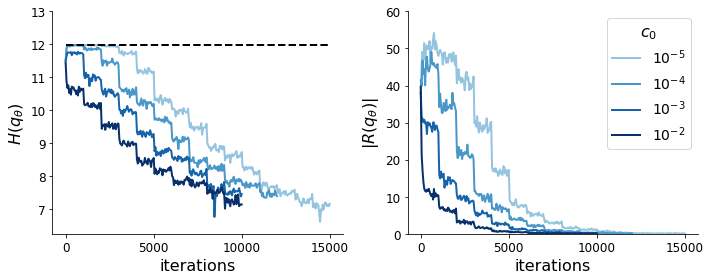

In [3]:
epi_df = M.get_epi_df()
epi_df['c0'] = [row['AL_hps']['c0'] for i, row in epi_df.iterrows()]
epi_df['Rnorm'] = [np.linalg.norm([row['R%d' % j] for j in range(1,5)])
                   for i, row in epi_df.iterrows()]
_epi_df = epi_df[epi_df['c0'] < 0.1]
H_max = -np.log(1/(20.**4))
c0s = sorted(_epi_df['c0'].unique())
log10_c0s =  np.log10(c0s)
c0_norm = (log10_c0s - log10_c0s.min()) + 2
c0_norm = c0_norm / c0_norm.max()
cmap = plt.get_cmap('Blues')
colors = cmap(c0_norm)

fontsize = 16

fig, axs = plt.subplots(1,2,figsize=(10,4))
for i, c0 in enumerate(c0s):
    _epi_df_i = _epi_df[_epi_df['c0']==c0]
    label_i = r'$10^{%d}$' % np.round(np.log10(c0))
    axs[0].plot(_epi_df_i['iteration'], _epi_df_i['H'], c=colors[i], label=label_i)
    axs[1].plot(_epi_df_i['iteration'], _epi_df_i['Rnorm'], c=colors[i], label=label_i)
    
[axs[i].set_xticks([0,5e3,10e3,15e3]) for i in range(2)]

axs[0].plot([0, _epi_df['iteration'].max()], [H_max, H_max], 'k--')  
axs[0].set_xlabel('iterations', fontsize=fontsize)
axs[0].set_ylabel(r'$H(q_{\theta})$', fontsize=fontsize)
axs[0].set_ylim([6.25, 13])

legend = axs[1].legend(title=r'$c_0$', fontsize=fontsize-2)
plt.setp(legend.get_title(),fontsize=fontsize)
axs[1].set_xlabel('iterations', fontsize=fontsize)
axs[1].set_ylabel(r'$|R(q_{\theta})|$', fontsize=fontsize)
axs[1].set_ylim([0, 60])
plt.tight_layout()
plt.savefig(os.path.join(figdir, "figLDS1", "epi_opt_by_c.pdf"))
plt.show()
    


In [4]:
_epi_df_i = _epi_df[_epi_df['c0']==1e-5]
df_row = _epi_df_i[_epi_df_i['iteration'] == _epi_df_i['iteration'].max()].iloc[0]
dist = M.get_epi_dist(df_row)
z, log_q_z = dist.nf(500)
z, log_q_z = z.numpy(), log_q_z.numpy()

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


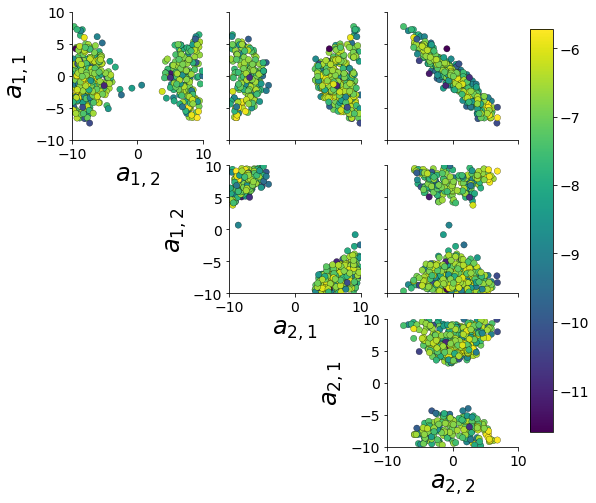

In [5]:
labels = [r'$a_{1,1}$', r'$a_{1,2}$', r'$a_{2,1}$', r'$a_{2,2}$']
fig, axs = pairplot(z, range(4), labels, figsize=(8,8),
                    lb=dist.nf.lb, ub=dist.nf.ub,
                    c=log_q_z, s=40,
                    fontsize=24, ticksize=14)
plt.savefig(os.path.join(figdir, "figLDS1", "epi_dist.png"), transparent=True)
plt.show()


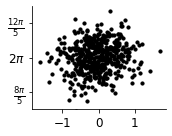

In [17]:
T_x = M.eps(z).numpy()
num_plot = 500
fig, ax = plt.subplots(1,1,figsize=(2.5,2))
ax.scatter(T_x[:num_plot,0], T_x[:num_plot,1], s=10, c='k')
ax.set_xticks([-1., 0., 1.])
ax.set_yticks([8.*np.pi/5., 2.*np.pi, 12.*np.pi/5.])
ax.set_yticklabels([r'$\frac{8 \pi}{5}$', r'$2\pi$', r'$\frac{12 \pi}{5}$'])
plt.xlabel('', fontsize=fontsize+8)
plt.ylabel('', fontsize=fontsize+8)
plt.ylim([7.*np.pi/5., 13.*np.pi/5.])
plt.tight_layout()
plt.savefig(os.path.join(figdir, "figLDS1", "epi_T_x.png"), transparent=True)
plt.show()

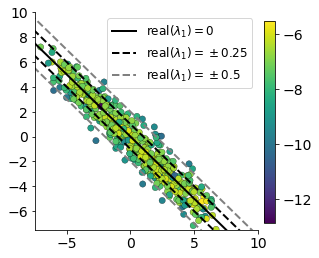

In [7]:
inds = [0,3]
_z = np.stack([z[:,ind] for ind in inds], axis=1)
#_labels = [labels[ind] for ind in inds]
_labels = ['' for ind in inds]
_lim = 7.5
fig, ax = pairplot(_z, range(2), _labels, figsize=(4,4),
                    lb=-_lim*np.ones(2,), ub=10.*np.ones(2,),
                    c=log_q_z, s=40,
                    fontsize=24, ticksize=14)

realstd = 0.5
#x1 = np.array([np.min(z[:,0]), np.max(z[:,0])])
x1 = np.array([-10., 10.])
ax.plot(x1, -x1, 'k')
ax.plot(x1, -(2*realstd)-x1, 'k--')
ax.plot(x1, -(4*realstd)-x1, '--', c='gray')
ax.plot(x1, +(2*realstd)-x1, 'k--')
ax.plot(x1, +(4*realstd)-x1, '--', c='gray')

legendstrs = [r'real$(\lambda_1) = 0$',
              r'real$(\lambda_1) = \pm0.25$',
              r'real$(\lambda_1) = \pm0.5$']

ax.legend(legendstrs, fontsize=12)
plt.savefig(os.path.join(figdir, "figLDS2", "epi_zoom_14.png"), transparent=True)

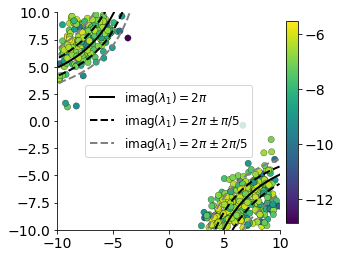

In [12]:
inds = [1,2]
_z = np.stack([z[:,ind] for ind in inds], axis=1)
#_labels = [labels[ind] for ind in inds]
_labels = ['' for ind in inds]
_lim = 10.
fig, ax = pairplot(_z, range(2), _labels, figsize=(4,4),
                    lb=-_lim*np.ones(2,), ub=_lim*np.ones(2,),
                    c=log_q_z, s=40,
                    fontsize=24, ticksize=14)

mean_14 = np.mean(z[:,0]*z[:,3])
std2 = 0.2*np.pi
x31 = np.linspace(np.min(z[:,2]), -0.01, 25)
x32 = np.linspace(0.01, np.max(z[:,2]), 25)

ax.plot(x31, (mean_14 -(2*np.pi)**2)/x31, 'k')
ax.plot(x31, (mean_14 -(std2 + (2*np.pi))**2)/x31, 'k--')
ax.plot(x31, (mean_14 -(2*std2 + (2*np.pi))**2)/x31, '--', c='gray')
ax.plot(x31, (mean_14 -(-std2 + (2*np.pi))**2)/x31, 'k--')
ax.plot(x31, (mean_14 -(-2*std2 + (2*np.pi))**2)/x31, '--', c='gray')

ax.plot(x32, (mean_14 -(2*np.pi)**2)/x32, 'k')
ax.plot(x32, (mean_14 -(std2 + (2*np.pi))**2)/x32, 'k--')
ax.plot(x32, (mean_14 -(2*std2 + (2*np.pi))**2)/x32, '--', c='gray')
ax.plot(x32, (mean_14 -(-std2 + (2*np.pi))**2)/x32, 'k--')
ax.plot(x32, (mean_14 -(-2*std2 + (2*np.pi))**2)/x32, '--', c='gray')

legendstrs = [r'imag$(\lambda_1) = 2 \pi$',
              r'imag$(\lambda_1) = 2 \pi \pm \pi/5$',
              r'imag$(\lambda_1) = 2 \pi \pm 2\pi/5$']
#ax.plot(x32, -((2*np.pi)**2)/x32, 'k')
#ax.plot(x32, (-std2 - ((2*np.pi)**2))/x32, 'k--')
#ax.plot(x32, (-2.0*std2 - ((2*np.pi)**2))/x32, '--', c='gray')
ax.legend(legendstrs, fontsize=12)
plt.savefig(os.path.join(figdir, "figLDS2", "epi_zoom_23.png"), transparent=True)


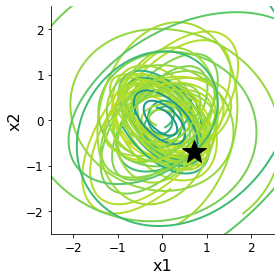

In [20]:
def simulate_2DLDS(x0, A, tau, dt, T):
    def f(x):
        return np.dot(A, x)
    
    x = np.zeros((2, T+1))
    x[:,0] = x0
    x_i = x0
    for i in range(T):
        x_i = x_i + (dt/tau)*f(x_i)
        x[:,i+1] = x_i
    return x

x0 = np.array([np.sqrt(2)/2, -np.sqrt(2)/2])
tau = 1.0
dt = 1e-3
T = 2000
num_sims = 25

cmap = plt.get_cmap('viridis')
norm_log_q_z = log_q_z - log_q_z.min()
norm_log_q_z = norm_log_q_z / np.abs(norm_log_q_z.max())
colors = cmap(norm_log_q_z)

fig, ax = plt.subplots(1,1,figsize=(4,4))
xs = []
for i in range(num_sims):
    A = np.reshape(z[i,:], (2,2))
    x = simulate_2DLDS(x0, A, tau, dt, T)
    xs.append(x)
    ax.plot(x[0], x[1], c=colors[i])
ax.plot([x0[0]], [x0[1]], 'k*', markersize=25)
_lim = 2.5
ax.set_xlim([-_lim, _lim])
ax.set_ylim([-_lim, _lim])
plt.xlabel('x1', fontsize=fontsize)
plt.ylabel('x2', fontsize=fontsize)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "figLDS3", "phase.png"), transparent=True)
plt.show()


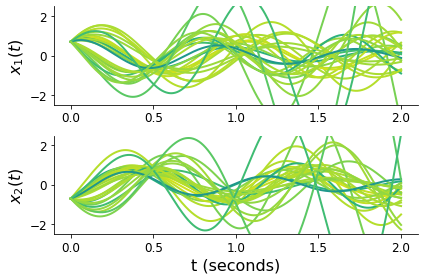

In [21]:
fig, axs = plt.subplots(2,1, figsize=(6,4))
t = dt*np.arange(T+1)
for i in range(num_sims):
    for j in range(2):
        axs[j].plot(t, xs[i][j], c=colors[i])
        
for j in range(2):
    axs[j].set_xticks([0,.5,1,1.5,2])
    axs[j].set_ylim([-_lim,_lim])
axs[1].set_xlabel('t (seconds)', fontsize=fontsize)
axs[0].set_ylabel(r'$x_1(t)$', fontsize=fontsize)
axs[1].set_ylabel(r'$x_2(t)$', fontsize=fontsize)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "figLDS3", "time.png"), transparent=True)
plt.show()